In [1]:
import os

# 数据路径配置
train_data_path = "../data/riddles/zimi/zimi_train_data.csv"
model_save_path = "../models/keyword_extractor"

# 模型和Tokenizer路径
# pretrained_model_name = "fnlp/bart-base-chinese"
pretrained_model_name = "../../model/bart-base-chinese"

# 超参数配置
max_length = 50
batch_size = 16
learning_rate = 5e-5
num_epochs = 3
test_size = 0.2
oversample_size = 0.5

# 检查并创建保存模型的目录
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)


In [2]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BartForConditionalGeneration, Text2TextGenerationPipeline
from torch.utils.data import Dataset, DataLoader
import torch
from collections import Counter
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score

2024-08-06 20:41:14.579812: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 20:41:14.620320: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 20:41:14.620353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 20:41:14.621352: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-06 20:41:14.627394: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 20:41:14.628563: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
# 安全地将字符串转换为原始格式（列表或字典），对于无效格式返回原始值。
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val) if not pd.isna(val) else val
    except (ValueError, SyntaxError):
        return val

# 读取数据
zimi_df = pd.read_csv(train_data_path).dropna()
zimi_df['拆字'] = zimi_df['拆字'].apply(safe_literal_eval)
zimi_df['pronunciation_details'] = zimi_df['pronunciation_details'].apply(safe_literal_eval)
zimi_df.head(5)


,字符,笔画数,拼音,偏旁部首,频率,结构代码,拆字,结构方式,间架比例,char,index,pinyin,pronunciation_details,结构谜底,拆字谜底,谜底,字谜
0,劲,7,jìn,力,1,H0,[圣 力],左右结构,左右结构,劲,926.0,jìn,"{'pinyin': 'jìn', 'explanations': [{'content':...",[左右],圣力,[左右]圣力,左侧执圣，右侧持力
1,拔,8,bá,扌,1,H2,"[手 犮, 扌 犮, 才 犮]",左右结构,左窄右宽,拔,959.0,bá,"{'pinyin': 'bá', 'explanations': [{'content': ...",[左右],手犮,[左右]手犮,弓的左侧，手待发之势；弓的右侧，犮射出之力
2,酒,10,jiǔ,酉,1,H0,"[水 酉, 氵 酉]",左右结构,左右结构,酒,2069.0,jiǔ,"{'pinyin': 'jiǔ', 'explanations': [{'content':...",[左右],水酉,[左右]水酉,左边是水，右边是酉
3,蟋,17,xī,虫,2,H2,[虫 悉],左右结构,左窄右宽,蟋,3411.0,xī,"{'pinyin': 'xī', 'explanations': [{'content': ...",[左右],虫悉,[左右]虫悉,左侧执虫，右侧持悉
4,栈,9,zhàn,木,2,H2,[木 戋],左右结构,左窄右宽,栈,1425.0,zhàn,"{'pinyin': 'zhàn', 'explanations': [{'content'...",[左右],木戋,[左右]木戋,门的左扇，木装饰之美；门的右扇，戋简约之雅


In [4]:
zimi_df[zimi_df["结构谜底"]=="[上中下]"]

,字符,笔画数,拼音,偏旁部首,频率,结构代码,拆字,结构方式,间架比例,char,index,pinyin,pronunciation_details,结构谜底,拆字谜底,谜底,字谜
299,鼻,14,bí,鼻,1,E0,[自 田 廾],上中下结构,上中下结构,鼻,3128.0,bí,"{'pinyin': 'bí', 'explanations': [{'content': ...",[上中下],自田廾,[上中下]自田廾,上段自轻盈如风，中段田稳如山，下段廾厚重如地
790,帚,8,zhǒu,巾,2,E0,[彐 冖 巾],上中下结构,上中下结构,帚,1306.0,zhǒu,"{'pinyin': 'zhǒu', 'explanations': [{'content'...",[上中下],彐冖巾,[上中下]彐冖巾,上层彐飘逸，中层冖凝练，下层巾沉着
1209,壹,12,yī,士,2,E0,[士 冖 豆],上中下结构,上中下结构,壹,2537.0,yī,"{'pinyin': 'yī', 'explanations': [{'content': ...",[上中下],士冖豆,[上中下]士冖豆,顶上士，中段冖，底下豆
1353,曼,11,màn,曰,2,E0,[曰 目 又],上中下结构,上中下结构,曼,2268.0,màn,"{'pinyin': 'màn', 'explanations': [{'content':...",[上中下],曰目又,[上中下]曰目又,上头曰点缀，中间目连接，下端又支撑
1728,害,10,hài,宀,1,E0,[宀 丰 口],上中下结构,上中下结构,害,2097.0,hài,"{'pinyin': 'hài', 'explanations': [{'content':...",[上中下],宀丰口,[上中下]宀丰口,上宀如同天空的日出，中丰如同午间的烈阳，下口如同黄昏的晚霞


In [5]:
data = zimi_df.copy()

inputs = data["字谜"].apply(lambda x: f"请抽取字谜中的关键字：{x}。字谜中的关键字是：")
outputs = data["拆字谜底"].apply(lambda x: f"{x}")

sft_dataset = pd.DataFrame({"input": inputs, "output": outputs})
sft_dataset.head()

,input,output
0,请抽取字谜中的关键字：左侧执圣，右侧持力。字谜中的关键字是：,圣力
1,请抽取字谜中的关键字：弓的左侧，手待发之势；弓的右侧，犮射出之力。字谜中的关键字是：,手犮
2,请抽取字谜中的关键字：左边是水，右边是酉。字谜中的关键字是：,水酉
3,请抽取字谜中的关键字：左侧执虫，右侧持悉。字谜中的关键字是：,虫悉
4,请抽取字谜中的关键字：门的左扇，木装饰之美；门的右扇，戋简约之雅。字谜中的关键字是：,木戋


In [6]:
sft_dataset[sft_dataset["output"]=="自田廾"]

,input,output
299,请抽取字谜中的关键字：上段自轻盈如风，中段田稳如山，下段廾厚重如地。字谜中的关键字是：,自田廾


In [7]:
class KeywordDataset(Dataset):
    def __init__(self, tokenizer, input_texts, target_texts, max_length):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.input_texts = input_texts
        self.target_texts = target_texts

        # 统计各类别样本数
        self.target_counts = Counter(target_texts)
        self.max_count = max(self.target_counts.values())

        # 进行过采样
        self.oversample()

    def oversample(self):
        new_input_texts = []
        new_target_texts = []

        target_count_limit = int(self.max_count * oversample_size)  # 设定目标样本数限制

        for target_text, count in self.target_counts.items():
            indices = [i for i, t in enumerate(self.target_texts) if t == target_text]
            sample_count = max(0, target_count_limit - count)

            if sample_count > 0:
                sampled_indices = random.choices(indices, k=sample_count)
                new_input_texts.extend([self.input_texts[i] for i in sampled_indices])
                new_target_texts.extend([self.target_texts[i] for i in sampled_indices])

        # 扩展原始数据集
        self.input_texts.extend(new_input_texts)
        self.target_texts.extend(new_target_texts)

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        input_text = self.input_texts[idx]
        target_text = self.target_texts[idx]

        input_encoding = self.tokenizer(input_text, padding='max_length', truncation=True, max_length=self.max_length, return_token_type_ids=False)
        target_encoding = self.tokenizer(target_text, padding='max_length', truncation=True, max_length=self.max_length, return_token_type_ids=False)

        inputs = {key: torch.tensor(val) for key, val in input_encoding.items()}
        targets = {key: torch.tensor(val) for key, val in target_encoding.items()}

        return inputs, targets

In [8]:
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)
model = BartForConditionalGeneration.from_pretrained(pretrained_model_name).to('cuda')

In [9]:
# 创建数据集和数据加载器
data = sft_dataset.copy()
dataset = KeywordDataset(tokenizer, list(data['input']), list(data['output']), max_length=max_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [10]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label='Training Loss', color='blue', linestyle='-', linewidth=2, marker='o')
    plt.plot(val_losses, label='Validation Loss', color='red', linestyle='--', linewidth=2, marker='x')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_accuracies(val_accuracies):
    plt.figure(figsize=(6, 4))
    plt.plot(val_accuracies, label='Validation Accuracy', color='green', linestyle='-', linewidth=2, marker='s')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def evaluate(model, val_loader, tokenizer):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            inputs = {k: v.to(model.device) for k, v in inputs.items()}
            targets = {k: v.to(model.device) for k, v in targets.items()}

            if 'token_type_ids' in inputs:
                del inputs['token_type_ids']

            outputs = model(**inputs, labels=targets['input_ids'])
            total_loss += outputs.loss.item()

            predictions = outputs.logits.argmax(dim=-1)

            for pred, target in zip(predictions, targets['input_ids']):
                pred_text = tokenizer.decode(pred, skip_special_tokens=True)
                target_text = tokenizer.decode(target, skip_special_tokens=True)
                all_predictions.append(pred_text)
                all_targets.append(target_text)

    avg_loss = total_loss / len(val_loader)
    val_accuracy = accuracy_score(all_targets, all_predictions)

    return avg_loss, val_accuracy

def train(model, dataloader, val_loader, model_path, tokenizer):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        total_loss = 0
        loop = tqdm(dataloader, leave=True)
        for batch in loop:
            inputs, targets = batch
            inputs = {k: v.to(model.device) for k, v in inputs.items()}
            targets = {k: v.to(model.device) for k, v in targets.items()}
            
            if 'token_type_ids' in inputs:
                del inputs['token_type_ids']
            
            outputs = model(**inputs, labels=targets['input_ids'])
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_description(f'Epoch {epoch}')
            loop.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(dataloader)
        val_loss, val_accuracy = evaluate(model, val_loader, tokenizer)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}%')

    plot_losses(train_losses, val_losses)
    plot_accuracies(val_accuracies)

    model.save_pretrained(model_path)
    tokenizer.save_pretrained(model_path)


Epoch 0: 100%|██████████| 158/158 [00:26<00:00,  5.95it/s, loss=0.0194] 


Epoch 0, Training Loss: 0.4545923605483155, Validation Loss: 0.011372085742054465, Validation Accuracy: 0.9423631123919308%


Epoch 1: 100%|██████████| 158/158 [00:25<00:00,  6.16it/s, loss=0.00254] 


Epoch 1, Training Loss: 0.002724852722765925, Validation Loss: 0.0036714369495960204, Validation Accuracy: 0.9740634005763689%


Epoch 2: 100%|██████████| 158/158 [00:25<00:00,  6.15it/s, loss=0.000187]


Epoch 2, Training Loss: 0.000641001594736229, Validation Loss: 0.003189411278237292, Validation Accuracy: 0.9740634005763689%


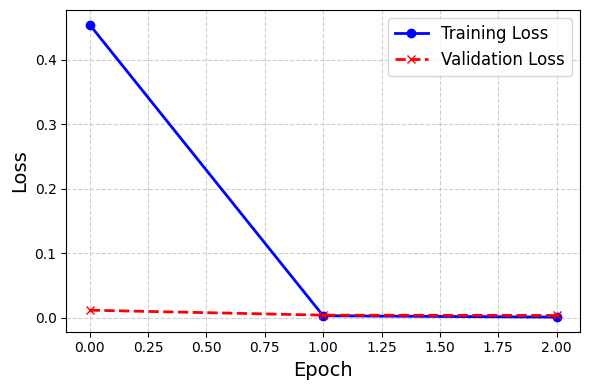

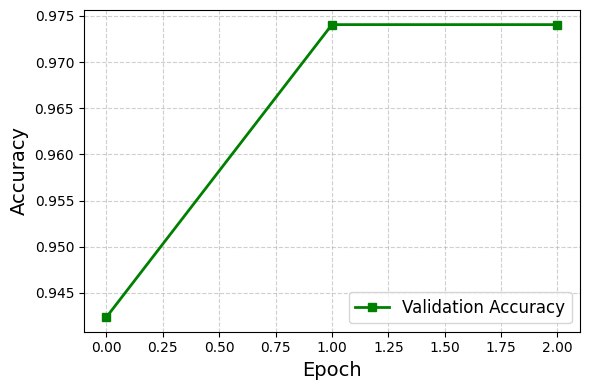

In [11]:
# 分割数据为训练集和验证集
train_data, val_data = train_test_split(data, test_size=test_size, random_state=42)

# 创建训练集的DataLoader
train_dataset = KeywordDataset(tokenizer, list(train_data['input']), list(train_data['output']), max_length=max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 创建验证集的DataLoader
val_dataset = KeywordDataset(tokenizer, list(val_data['input']), list(val_data['output']), max_length=max_length)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 开始训练并保存模型
train(model, train_loader, val_loader, model_save_path, tokenizer)


In [12]:
text2text_generator = Text2TextGenerationPipeline(model.to('cpu'), tokenizer)
example = "请抽取字谜中的关键字：上段自轻盈如风，中段田稳如山，下段廾厚重如地。字谜中的关键字是：[MASK]"
output = text2text_generator(example, max_length=max_length, do_sample=False)
print(output)


[{'generated_text': '自 田 廾'}]
